In [1]:
import os
import sys
import numpy as np
sys.path.append(os.getcwd()+"/python")
os.environ["ROOT_DIR"] = os.getcwd()# 12-13-22 note to change to more permanent dir  after testing
os.environ["DESGW_DIR"]=os.getcwd()+"/python"
os.environ["KNLC_ROOT"]=os.environ["ROOT_DIR"]+"/python"
os.environ["DATA_DIR"]=os.environ["ROOT_DIR"]+"/data"
os.environ["WEB"]=os.environ["ROOT_DIR"]+"/DES_GW_website"
os.environ["DESGW_MAP_DIR"]=os.environ["ROOT_DIR"]+"/skymaps"
os.environ["PYTHONPATH"]=os.environ["ROOT_DIR"]+"/python:$PYTHONPATH"
import python.OneRing as oneRing
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import hp2np 
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as u

# How deep will LSST DR1 be?

In [ ]:
def m_5(c_m,m_sky,theta_eff,t_vis,k_m,X):
    '''
    Deriving the 5 sigma magnitudes in a given LSST band for a given number of exposures/years/visits. 
    Derived from table 2 of https://iopscience.iop.org/article/10.3847/1538-4357/ab042c/pdf

    Inputs
    ------
    c_m: Band dependent parameter
    m_sky: Expected median sky brightness at cerro Pacho (AB mag arcsec^-2)
    theta_eff: Effective zenith seeing (arcseconds)
    t_vis: Exposure time (seconds)
    k_m: Atmospheric extinction coefficient
    X: Airmass
    
    Returns
    ------
    m_5: the 5-sigma limiting magnitude
    
    Other notes
    ------

    '''
    return c_m+0.5*(m_sky-21)+2.5*np.log(0.7/theta_eff)+1.25*np.log(t_vis/30)-k_m*(X-1)

In [ ]:
param_dict = {"y":[22.45,18.61,0.76,0.076,30*160],
              "z":[23.34,19.60,0.78,0.069,30*160],
              "i":[23.92,20.48,0.80,0.096,30*180],
              "r":[24.44,21.20,0.83,0.126,30*180],
              "g":[24.42,22.26,0.87,0.213,30*80],
              "u":[23.09,22.99,0.92,0.491,30*50]} # c_m,m_sky,theta_eff,k_m, t_vis

In [4]:
for band in param_dict.keys():
    c_m,m_sky,theta_eff,k_m, t_vis = param_dict[band]
    X=1.5
    print(band, np.round(m_5(c_m,m_sky,theta_eff,t_vis,k_m,X),3))

y 27.355
z 28.679
i 29.769
r 30.542
g 29.878
u 28.046


# All skymap

In [ ]:
comCamTargets = ((53.13, -28.10,"ECDFS"),(59.10, -48.73,"EDFS"),(37.86, 6.98,"Low Ecliptic Latitude Field"),
                 (95.00, -25.00,"Low Galactic Latitude Field"),(6.02, -72.08,"47 Tuc"),(40.00, -34.45,"Fornax Dwarf Spheroidal"))

In [ ]:
def plotCircle(center, radius=0.5*u.deg):
    x,y = center[0]*u.degree,center[1]*u.degree
    angles = np.arange(0,2*np.pi,step=0.05)
    return x+radius*np.cos(angles),y+radius*np.sin(angles)

In [6]:
comCamVisitDF = pd.read_csv("./data/comCamVisits.csv")

In [7]:
EDFS_visits = comCamVisitDF[np.logical_and(np.logical_and(comCamVisitDF["ra"] > 45 , comCamVisitDF["ra"] < 60),np.logical_and(comCamVisitDF["dec"] < -35 , comCamVisitDF["dec"] > -60))]

In [9]:
colorDict = {"y":"red",
              "z":"orange",
              "i":"yellow",
              "r":"green",
              "g":"blue",
              "u":"purple"} # c_m,m_sky,theta_eff,k_m, t_vis

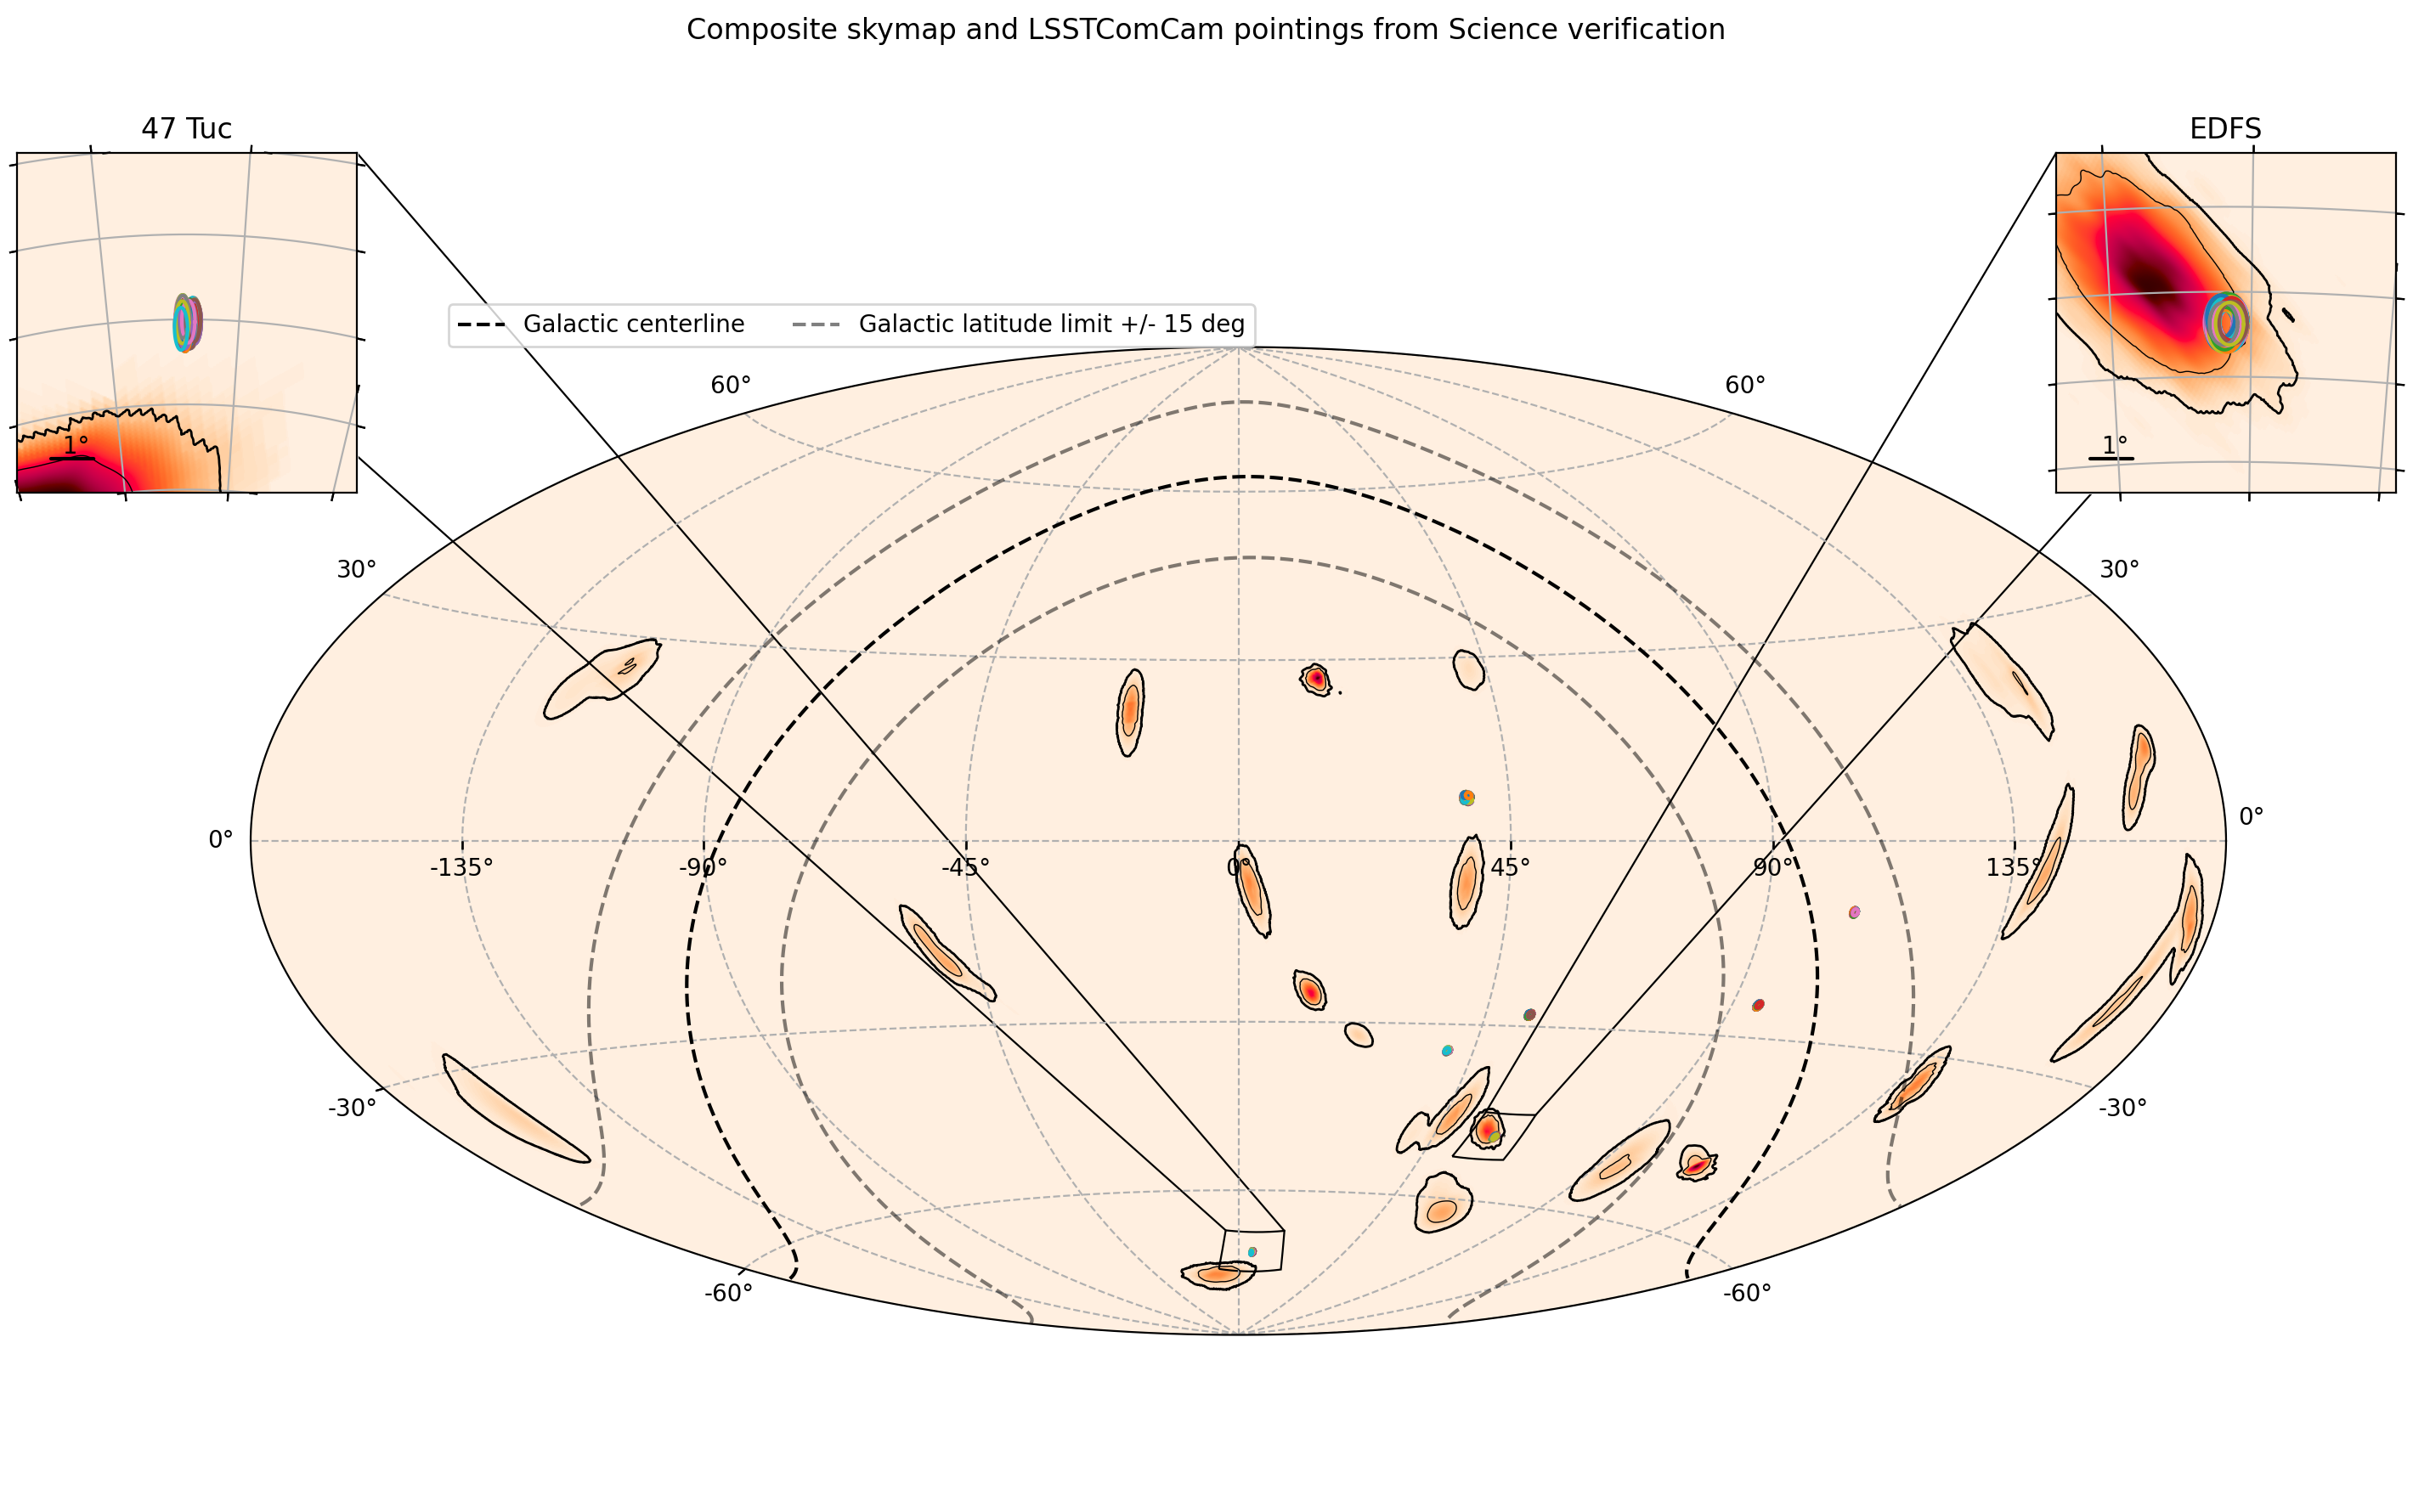

In [58]:
date = str(datetime.date.today())

skymap = hp.read_map("/data/des70.a/data/desgw/O4/Main-Injector-O4b/data/sirenas_combined_skymap.fits",)
npix = len(skymap)
nside = hp.npix2nside(npix)

prob  = skymap

npix = len(prob)
nside = hp.npix2nside(npix)

maxprobcoord_tup = hp.pix2ang(nside, np.argmax(prob))
maxprobcoord = [0, 0]
maxprobcoord[1] = np.rad2deg(0.5*np.pi-maxprobcoord_tup[0])
maxprobcoord[0] = np.rad2deg(maxprobcoord_tup[1])

def find_area(prob_array, contours, nside = nside):
    areas = []
    for contour in contours:
        sortedprob = np.sort(prob_array)
        probsum = 0
        probcutoff = 1
        npix = 0
        while probsum<contour:
            probsum = probsum+sortedprob[-1]
            probcutoff = sortedprob[-1]
            sortedprob = sortedprob[:-1]
            npix = npix+1

        area = npix * hp.nside2pixarea(nside, degrees=True)
        areas.append(area)
    return ([int(round(i,0)) for i in areas])

def ci(level, sorted_prob=np.flip(np.sort(prob))):
    csum = 0
    c = 0
    index = 0
    while csum < level:
        csum += sorted_prob[index]
        c = sorted_prob[index]
        index += 1
    return c

c50 = ci(.5)
c90 = ci(.9)
levels = [c90, c50]
    
area50, area90 = find_area(prob, contours = [.5, .9])

maxprob_ra = round(maxprobcoord[0],2)
maxprob_dec = round(maxprobcoord[1],2)

fig = plt.figure(figsize=(15, 10), dpi=200)

plt.box(False)
plt.xticks([])
plt.yticks([])

ax = plt.axes(projection='geo degrees aitoff')

for center,axCoords in zip([(59.10, -48.73,"EDFS"),(6.02, -72.08,"47 Tuc")],[[0.8, 0.7, 0.2, 0.2],[0, 0.7, 0.2, 0.2]]):
    ax_inset = plt.axes(
            axCoords,
            projection='geo degrees zoom',
            center=SkyCoord(ra=(center[0])*u.degree,dec=center[1]*u.degree,frame='icrs'),
            radius=4*u.deg)

    for key in ['pos.bodyrc.lat', 'pos.bodyrc.lon']:
        ax_inset.coords[key].set_ticklabel_visible(False)
        ax_inset.coords[key].set_ticks_visible(True)

    ax_inset.grid()
    ax.mark_inset_axes(ax_inset)
    ax.connect_inset_axes(ax_inset, 'upper left')
    ax.connect_inset_axes(ax_inset, 'upper right')
    ax_inset.scalebar((0.1, 0.1), 1 * u.deg).label()

    ax_inset.imshow_hpx(skymap, cmap='cylon')
    cs = ax_inset.contour_hpx(skymap, levels = levels, colors = ['black'], linewidths = [1,0.5])
    
    for id,row in comCamVisitDF.iterrows():
        points = plotCircle((row['ra'],row['dec']))
        ax_inset.plot(points[0],points[1],transform = ax_inset.get_transform("world"))
    ax_inset.set_title(center[2])

ax.imshow_hpx(skymap, cmap='cylon')
cs = ax.contour_hpx(skymap, levels = levels, colors = ['black'], linewidths = [1,0.5])

### Add galactic plane and +- 15 deg to skymap plot 

seanLimit = 15 # The upper and lower limit on the galactic latitude range - typically, this is 15 degrees
galacticLatitude = np.append(np.arange(0,359,step=1)-180/np.pi, [])

galacticCenterline = np.full(np.shape(galacticLatitude),0)
galacticLowerLimit = np.full(np.shape(galacticLatitude),-seanLimit)
galacticUpperLimit = np.full(np.shape(galacticLatitude),seanLimit)

galacticCenterlineCoords = SkyCoord(l=galacticLatitude*u.degree,b=galacticCenterline*u.degree,frame='galactic')
galacticLowerLimitCoords = SkyCoord(l=galacticLatitude*u.degree,b= galacticLowerLimit*u.degree,frame='galactic')
galacticUpperLimitCoords = SkyCoord(l=galacticLatitude*u.degree,b= galacticUpperLimit*u.degree,frame='galactic')

# plot it

galaxyKwargs = {"Center": {'ls':"--",'color':'black','label':"Galactic centerline"},
                "Upper limit": {'ls':"--","color":'black','alpha':0.5,'label':"Galactic latitude limit +/- {} deg".format(seanLimit)},
                "Lower limit": {'ls':"--","color":'black','alpha':0.5}}

for coord,label,galkey in zip([galacticCenterlineCoords,galacticLowerLimitCoords,galacticUpperLimitCoords],["Galactic center","Galactic lower limit","Galactic upper limit"],galaxyKwargs.keys()):
    galRa = coord.icrs.ra
    galDec = coord.icrs.dec
    ax.plot(np.array(galRa)-90,galDec,transform=ax.get_transform('icrs'),**galaxyKwargs[galkey])

for id,row in comCamVisitDF.iterrows():
    points = plotCircle((row['ra'],row['dec']))
    coord = SkyCoord(points[0],points[1])
    ax.plot(coord.icrs.ra,coord.icrs.dec,transform=ax.get_transform('world'))
fig.suptitle("Composite skymap and LSSTComCam pointings from Science verification")
ax.legend(loc = (0.1,1),ncols=2)
ax.grid(ls="--")
# fig.tight_layout()
plt.show()

In [59]:
fig.savefig("./SkyMapComCam.png",dpi=200)

In [8]:
print("Band","expTime", "n_obs",sep='\t')
for band in ["u","g","r","i","z","y"]:
    subsetDF = EDFS_visits[EDFS_visits['band']==band]
    print(band,np.sum(subsetDF['expTime']),len(subsetDF),sep='\t')

Band	expTime	n_obs
u	760.0	20
g	1830.0	61
r	2610.0	87
i	1260.0	42
z	1260.0	42
y	600.0	20


(5010.0, 167)